In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from itertools import combinations
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

# Download necessary NLTK packages
try:
    nltk.download('punkt_tab')
except Exception as e:
    print(f"Errore durante il download dei pacchetti NLTK: {e}")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
df = pd.read_csv("../PreProcessing/processed_data/Resume_proc.csv")

In [3]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Category'])

In [4]:
tagged_train = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train['Resume_str'])]
tagged_test = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(test['Resume_str'])]

In [5]:
d2v_model = Doc2Vec(
    vector_size=100, 
    window=15,
    min_count=1,
    dm=0,
    epochs=5,
    workers=8
)

In [6]:
d2v_model.build_vocab(tagged_train)
d2v_model.train(tagged_train, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [7]:
X_train = np.array([d2v_model.dv[str(i)] for i in range(len(tagged_train))])
y_train = train['Category']

In [8]:
X_test = np.array([d2v_model.infer_vector(tagged_test[i][0]) for i in range(len(tagged_test))])
y_test = test['Category']

In [9]:
# Print the sizes of the split datasets
print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (1986, 100)
Validation data size: (497, 100)


In [10]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
class_counts = y_train.value_counts()
min_classes = class_counts[class_counts < class_counts.mean()].index.tolist()

print(f"Applicazione di SMOTE alle classi: {min_classes}")

target_size = int(class_counts.max())
sampling_strategy = {cls: target_size for cls in min_classes}

Applicazione di SMOTE alle classi: ['CHEF', 'AVIATION', 'BANKING', 'DIGITAL-MEDIA', 'FITNESS', 'ADVOCATE', 'APPAREL', 'BPO', 'AGRICULTURE', 'ARTS', 'AUTOMOBILE']


In [13]:
pipeline = Pipeline(steps=[
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [14]:
param_grid = {
    'clf__n_estimators': [400, 700],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__max_depth' : [5, 7, 9],
    'clf__criterion' : ['gini', 'entropy'],
    'clf__min_samples_split': [10],
    'clf__min_samples_leaf': [15]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='f1_weighted',
    return_train_score=True,
    n_jobs=-1
)

start = time()
grid_search = grid.fit(X_train, y_train)

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")
report(grid_search.cv_results_)

c:\Users\andre\anaconda3\envs\ResumeProject\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
48 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\andre\anaconda3\envs\ResumeProject\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\andre\anaconda3\envs\ResumeProject\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\andre\anaconda3\envs\ResumeProject\Lib\site-

GridSearchCV took 539.26 seconds for 24 candidates parameter settings.

Model with rank: 1
Mean validation score: nan (std: nan)
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 400}

Model with rank: 1
Mean validation score: nan (std: nan)
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 700}

Model with rank: 1
Mean validation score: nan (std: nan)
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 400}

Model with rank: 1
Mean validation score: nan (std: nan)
Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 700}



In [15]:
print(grid_search.best_params_)

{'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 400}


In [16]:
# DataFrame con i risultati
results = pd.DataFrame(grid_search.cv_results_)
param_cols = [col for col in results.columns if col.startswith("param_")]

# Converti tutti i parametri in stringa per la pivot table
for p in param_cols:
    results[p] = results[p].astype(str)

# Heatmap per ogni coppia di parametri
for p1, p2 in combinations(param_cols, 2):
    try:
        pivot_val = results.pivot_table(values='mean_test_score', index=p1, columns=p2)
        pivot_train = results.pivot_table(values='mean_train_score', index=p1, columns=p2)

        if pivot_val.shape[0] > 1 and pivot_val.shape[1] > 1:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))

            sns.heatmap(pivot_train, annot=True, fmt=".3f", cmap="Blues", ax=axes[0])
            axes[0].set_title(f"Train Score")
            axes[0].set_xlabel(p2.replace("param_", ""))
            axes[0].set_ylabel(p1.replace("param_", ""))

            sns.heatmap(pivot_val, annot=True, fmt=".3f", cmap="Greens", ax=axes[1])
            axes[1].set_title(f"Validation Score")
            axes[1].set_xlabel(p2.replace("param_", ""))
            axes[1].set_ylabel("")

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Errore con {p1} e {p2}: {e}")


In [17]:
RF_Model_best = grid_search.best_estimator_
prediction = RF_Model_best.predict(X_test)

In [18]:
print("Training Score: {:.2f}".format(RF_Model_best.score(X_train, y_train)))
print("Test Score: {:.2f}".format(RF_Model_best.score(X_test, y_test)))

Training Score: 0.56
Test Score: 0.50


In [19]:
print(classification_report(y_test, prediction, zero_division=0))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.62      0.89      0.73        27
              ADVOCATE       0.27      0.54      0.36        13
           AGRICULTURE       0.36      0.67      0.47         6
               APPAREL       0.28      0.64      0.39        11
                  ARTS       0.10      0.75      0.18         4
            AUTOMOBILE       0.05      0.50      0.10         2
              AVIATION       0.56      0.74      0.64        19
               BANKING       0.36      0.44      0.40        18
                   BPO       0.00      0.00      0.00        10
  BUSINESS-DEVELOPMENT       0.73      0.24      0.36        34
                  CHEF       0.67      1.00      0.80        20
          CONSTRUCTION       0.86      0.55      0.67        22
            CONSULTANT       0.00      0.00      0.00        25
              DESIGNER       0.33      0.05      0.08        22
         DIGITAL-MEDIA       0.35      

<Figure size 1500x1000 with 0 Axes>

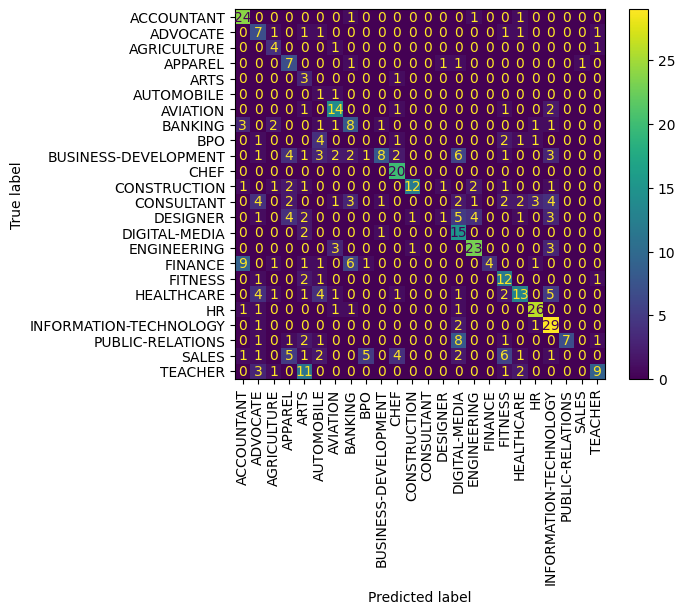

In [20]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()

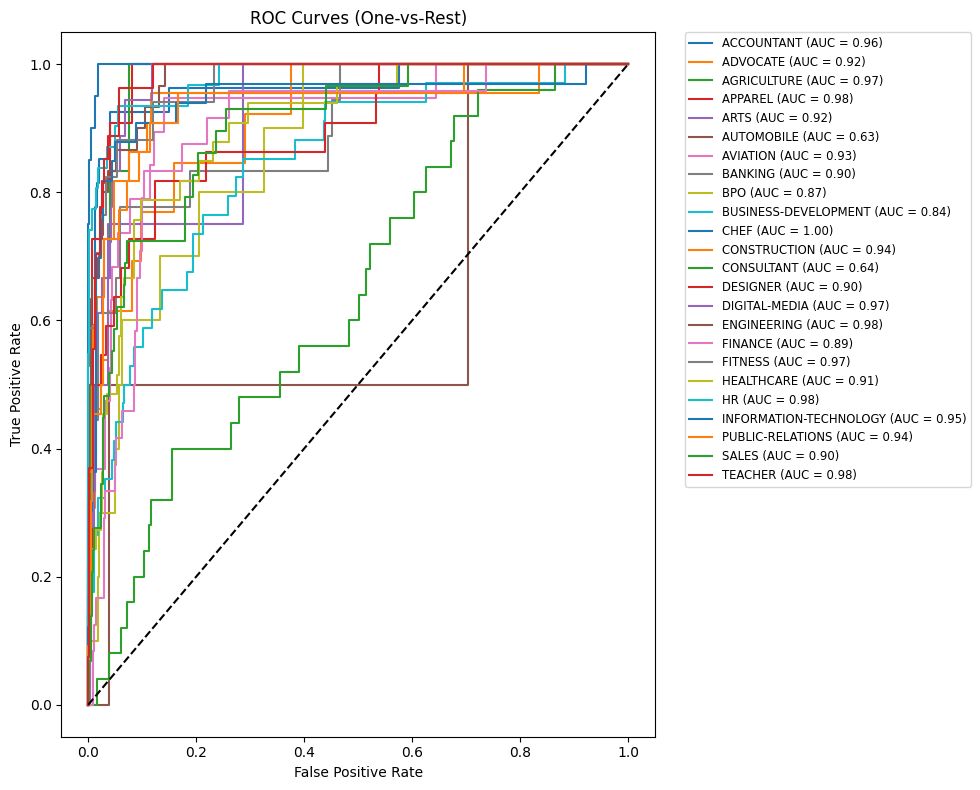

In [21]:
y_test_bin = label_binarize(y_test, classes=RF_Model_best.classes_)
y_score = RF_Model_best.predict_proba(X_test)

plt.figure(figsize=(10, 8))

for i in range(len(RF_Model_best.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{RF_Model_best.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")

# Sposta la legenda fuori dal grafico
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()

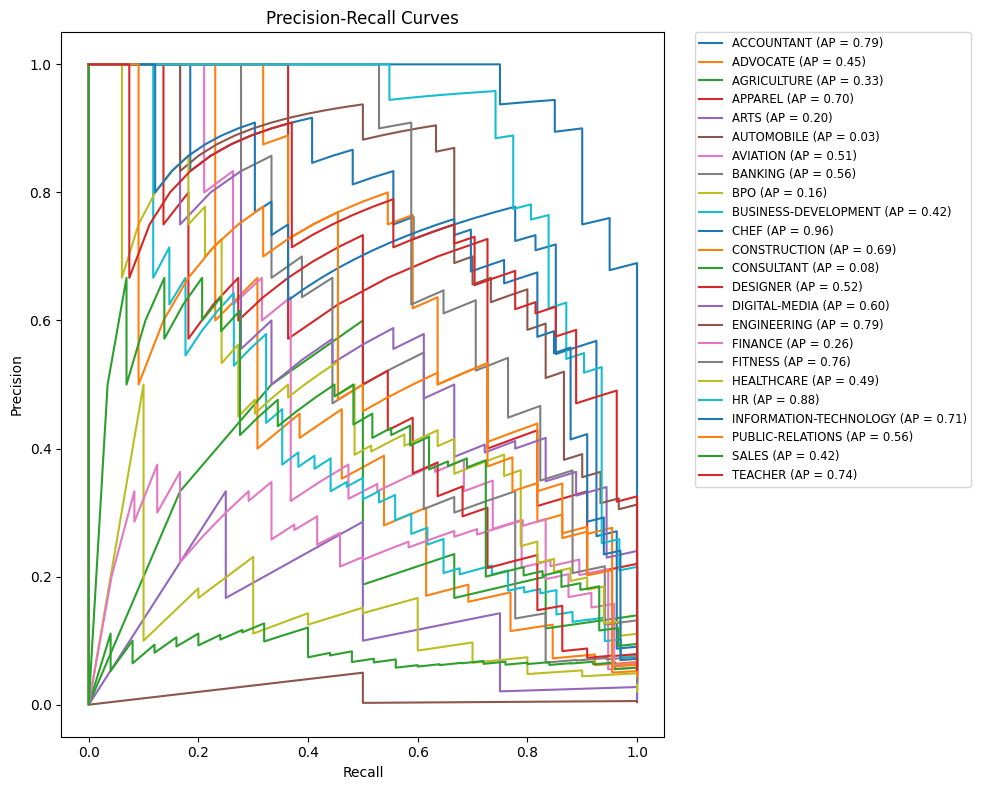

In [22]:
plt.figure(figsize=(10, 8))

for i in range(len(RF_Model_best.classes_)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{RF_Model_best.classes_[i]} (AP = {avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")

# Legenda esterna a destra
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
plt.tight_layout()
plt.show()

In [23]:
import sys
sys.path.append('..')

from utils import save_experiment_D2V

save_experiment_D2V(d2v_model, grid_search, RF_Model_best, X_train, y_train, X_test, y_test)

✅ Riga di log aggiunta in 'experiment_log.txt':
RandomForestClassifier(clf__criterion=gini, clf__max_depth=5, clf__max_features=sqrt, clf__min_samples_leaf=15, clf__min_samples_split=10, clf__n_estimators=400) | D2V(vector_size=100, window=15, min_count=1, dm=False, epochs=5) | Accuracy train=0.562, test=0.497

